In [91]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from lightgbm import LGBMClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import joblib 
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score,confusion_matrix
from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.preprocessing import Reweighing
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, train_test_split


## Loading the Dataset

In [92]:
columns = [
    "age", "workclass", "fnlwgt", "education", "education_num",
    "marital_status", "occupation", "relationship", "race", "sex",
    "capital_gain", "capital_loss", "hours_per_week", "native_country", "income"
]

main_data = pd.read_csv('../adult/adult.data', names=columns,na_values=' ?')


In [93]:
X = main_data.drop('income', axis=1)
y = main_data['income']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [94]:
train_data = X_train_val.copy()
train_data['income'] = y_train_val

test_data = X_test.copy()
test_data['income'] = y_test

In [95]:
test_data['income'] = test_data['income'].apply(lambda x:x.strip())
test_data['income'] = test_data['income'].apply(lambda x:x.replace('.', ''))
train_data['income'] = train_data['income'].apply(lambda x:x.strip())


In [96]:
## Removing the Rows with Null values
train_data = train_data.dropna().reset_index(drop=True)
test_data = test_data.dropna().reset_index(drop=True)
print("Training Data Shape:",train_data.shape)
print("Test Data Shape:",test_data.shape)

Training Data Shape: (24134, 15)
Test Data Shape: (6028, 15)


In [97]:
train_data['income'] = train_data['income'].apply(lambda x: 1 if x=='>50K' else 0)
test_data['income'] = test_data['income'].apply(lambda x: 1 if x=='>50K' else 0)

## Exploratory Fairness Analysis

In [98]:
protected_attributes = ['age','sex']

In [99]:
## Binarizing the Age on the basis of threshold 25 years old  <=25 : youth and >25 senior 
train_data['age_cat'] = train_data['age'].apply(lambda x: "senior" if x>25 else "youth")
test_data['age_cat'] = test_data['age'].apply(lambda x: "senior" if x>25 else "youth")

Text(0.5, 1.0, 'Age Category')

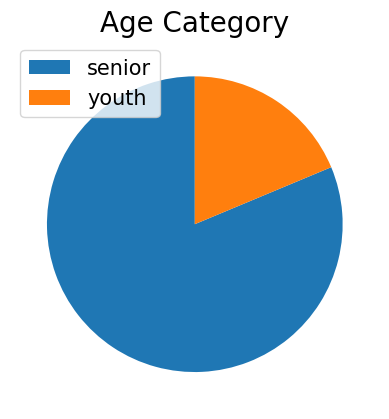

In [100]:
counts = train_data['age_cat'].value_counts()
labels = counts.index

#Plot pie chart
plt.pie(counts, startangle=90)
plt.legend(labels, loc=2,fontsize=15)
plt.title("Age Category",size=20)

Text(0.5, 1.0, 'Gender')

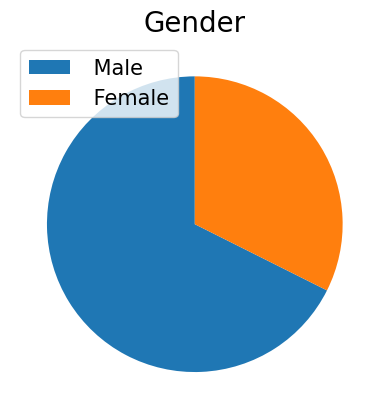

In [101]:
counts = train_data['sex'].value_counts()
labels = counts.index

#Plot pie chart
plt.pie(counts, startangle=90)
plt.legend(labels, loc=2,fontsize=15)
plt.title("Gender",size=20)

Two Observations we can make from this plot is that there are Majority Senior People (age>25) and Males in the dataset.

In [103]:
fair_df = train_data[['age_cat','sex','income']]

## Encoding 1 for the privileged classes as in this case senior and male adults

fair_df['age_cat'] = fair_df['age_cat'].apply(lambda x: 1 if x=='senior' else 0)
fair_df['sex'] = fair_df['sex'].apply(lambda x: 1 if x==' Male' else 0)
# fair_df['income'] = fair_df['income'].apply(lambda x: 1 if x=='>50K' else 0)

/var/folders/51/y2_6x05j1hjgtnzwshx1dgt80000gn/T/ipykernel_40889/1898271901.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fair_df['age_cat'] = fair_df['age_cat'].apply(lambda x: 1 if x=='senior' else 0)
/var/folders/51/y2_6x05j1hjgtnzwshx1dgt80000gn/T/ipykernel_40889/1898271901.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fair_df['sex'] = fair_df['sex'].apply(lambda x: 1 if x==' Male' else 0)


In [104]:
prev = fair_df['income'].mean()
prev_age = fair_df.groupby('age_cat')['income'].mean()
prev_sex = fair_df.groupby('sex')['income'].mean()
prev_comb = fair_df.groupby(['age_cat','sex'])['income'].mean()

In [105]:
prev*100

np.float64(24.89019640341427)

In [106]:
prev_age*100

age_cat
0     1.927764
1    30.171755
Name: income, dtype: float64

In [107]:
prev_sex*100

sex
0    11.167967
1    31.464117
Name: income, dtype: float64

In [108]:
prev_comb.unstack()*100

sex,0,1
age_cat,,
0,1.283368,2.417154
1,14.448799,36.881908


We are checking prevalence for the protected attributes and can clearly see that for each protected group the privileged class has much more prevelance like senior have 30% and male have 31% prevelance in the dataset and also the senior male has the highest prevelance i.e 36% in this case. As this dataset was built using United States census data from 1994 it clearly shows the lack of working opportunity for the youth to raise high income and gender discrimination.

## Modelling Classifier

In [109]:
train_data['age_cat'] = train_data['age_cat'].apply(lambda x:1 if x=='senior' else 0)
train_data['sex'] = train_data['sex'].apply(lambda x:1 if x ==" Male" else 0)

In [110]:
def create_folds(df,n_folds):
    
    df['kfold'] = -1
    y = df.income
    
    kf = StratifiedKFold(n_splits=n_folds)
    
    for f,(t_,v_) in enumerate(kf.split(X=df,y=y)):
        df.loc[v_,'kfold'] = f
        
    return df

In [111]:
models = {

    "lgbm" : LGBMClassifier(objective="binary",verbose=-1)

}

In [112]:
def run_folds(df,fold,model):
    

    categorical_cols = [
                'workclass', 'education', 'marital_status', 'occupation',
                'relationship', 'race', 'native_country'
                        ]
    numerical_cols = ['fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week','sex','age_cat']

    preprocessor = ColumnTransformer(
            transformers=[
                ('num', 'passthrough', numerical_cols),
                ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_cols)
            ])

    
    df_train = df[df.kfold!=fold].reset_index(drop=True)
    df_valid = df[df.kfold==fold].reset_index(drop=True)
    
    
    x_train = df_train.drop(columns=['income','age','kfold'],axis=1)
    y_train = df_train.income.values
    
    x_valid = df_valid.drop(columns=['income','age','kfold'],axis=1)
    y_valid = df_valid.income.values
    
    x_train = preprocessor.fit_transform(x_train)
    x_valid = preprocessor.transform(x_valid)
    
    
    clf = models[model]
    
    clf.fit(x_train,y_train)
    y_train_pred = clf.predict(x_train)
    y_valid_pred = clf.predict(x_valid)
    
    train_precision = precision_score(y_train, y_train_pred, average='macro')  
    train_recall = recall_score(y_train, y_train_pred, average='macro')
    train_f1_score = f1_score(y_train, y_train_pred, average='macro')


    valid_precision = precision_score(y_valid, y_valid_pred, average='macro')  
    valid_recall = recall_score(y_valid, y_valid_pred, average='macro')
    valid_f1_score = f1_score(y_valid, y_valid_pred, average='macro')


    joblib.dump(preprocessor,f"../model/{model}/preprocessing_{fold}.pkl")
    joblib.dump(clf,f"../model/{model}/{model}_{fold}.pkl")



    print(f'Fold {fold}')
    print(f'Train F1 Score:{train_f1_score}, Train Precision:{train_precision}, Train Recall: {train_recall}')
    print(f'Validation F1 Score:{valid_f1_score}, Validation Precision:{valid_precision}, Validation Recall: {valid_recall}')
    print('*'*50)
    
    
    return train_precision, train_recall, train_f1_score , valid_precision, valid_recall, valid_f1_score



In [113]:
def get_stats(train_data,model_name,n_folds):
    train_p = []
    train_r = []
    train_f1 = []
    val_p = []
    val_r = []
    val_f1 = []
    
    train_data = create_folds(train_data,n_folds)

    for i in range(n_folds):

        tp, tr, tf1, vp, vr, vf1 = run_folds(train_data,i,model_name)
        train_p.append(tp)
        train_r.append(tr)
        train_f1.append(tf1)
        val_p.append(vp)
        val_r.append(vr)
        val_f1.append(vf1)
    

    print("*"*15,"Final Summary","*"*15)

    print(f"average training precision:{np.array(train_p).mean()}")
    print(f"average training recall:{np.array(train_r).mean()}")
    print(f"average training f1:{np.array(train_f1).mean()}")


    print(f"average validation precision:{np.array(val_p).mean()}")
    print(f"average validation recall:{np.array(val_r).mean()}")
    print(f"average validation f1:{np.array(val_f1).mean()}")
        

In [115]:
get_stats(train_data,'lgbm',5)

Fold 0
Train F1 Score:0.8333868019678512, Train Precision:0.8577147979212141, Train Recall: 0.8155899197082292
Validation F1 Score:0.8090723220715673, Validation Precision:0.8372588521479759, Validation Recall: 0.7898058408399793
**************************************************
Fold 1
Train F1 Score:0.8360483178050249, Train Precision:0.8602770719327681, Train Recall: 0.8182578354759924
Validation F1 Score:0.8036050774862911, Validation Precision:0.8272333973198971, Validation Recall: 0.7867735383556143
**************************************************
Fold 2
Train F1 Score:0.8312682963684669, Train Precision:0.8563695694780166, Train Recall: 0.8130898344060706
Validation F1 Score:0.8239388999084785, Validation Precision:0.840870755656437, Validation Recall: 0.8106373251193044
**************************************************
Fold 3
Train F1 Score:0.8365592580161437, Train Precision:0.8591006729265218, Train Recall: 0.8197148887202033
Validation F1 Score:0.8010449521783249, Validat

Fold 2 Model has the best validation score so for the rest of the modelling i will use fold 8 preprocessor and lgbm model

## Model Fairness Assessment

In [116]:
fold = 2
selected_processor = joblib.load(f"../model/lgbm/preprocessing_{fold}.pkl")
selected_model = joblib.load(f"../model/lgbm/lgbm_{fold}.pkl")

In [118]:
X_test = test_data.drop(columns=['age','income'])
y_test = test_data.income

In [119]:
X_test['age_cat'] = X_test['age_cat'].apply(lambda x:1 if x=='senior' else 0)
X_test['sex'] = X_test['sex'].apply(lambda x:1 if x ==" Male" else 0)

In [120]:
X_test = selected_processor.transform(X_test)
y_test_prediction = selected_model.predict(X_test)

In [121]:
print(classification_report(y_test,y_test_prediction))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      4527
           1       0.79      0.66      0.72      1501

    accuracy                           0.87      6028
   macro avg       0.84      0.80      0.82      6028
weighted avg       0.87      0.87      0.87      6028



In [122]:
test_data['income_pred'] = y_test_prediction

In [123]:
def fairness_metrics(df):
    """Calculate fairness for subgroup of population"""
    
    #Confusion Matrix
    cm=confusion_matrix(df['income'],df['income_pred'])
    TN, FP, FN, TP = cm.ravel()
    
    N = TP+FP+FN+TN #Total population
    ACC = (TP+TN)/N #Accuracy
    TPR = TP/(TP+FN) # True positive rate
    FPR = FP/(FP+TN) # False positive rate
    FNR = FN/(TP+FN) # False negative rate
    PPP = (TP + FP)/N # % predicted as positive
    
    return np.array([ACC, TPR, FPR, FNR, PPP])



## Accuracy Should is not a good indicator to check the fairness of the model
## True Positive Rate is percentage of people rightfully benefitted from the model
## False Negative rate is percentage of people who have wrongfully not benefitted from the model
## False Positive Rate is percentage of people who wrongfully benefitted from the model
## PPP (Disparate Impact) Percentage of people who will benefit from the model

In [124]:
def get_faireness_stats(lst,cols):

    return pd.DataFrame(lst,index=cols,
                        columns=['accuracy','true_positive_rate','false_positive_rate','false_negative_rate','disparate_impact'])

In [125]:
# Privileged Group is Senior and Unprivileged Group is Youth

fm_age_1 = fairness_metrics(test_data[test_data.age_cat=="senior"])
fm_age_0 = fairness_metrics(test_data[test_data.age_cat=="youth"])



#Get ratio of fairness metrics
fm_age = fm_age_0/fm_age_1


get_faireness_stats([fm_age_1,fm_age_0,fm_age],['senior','youth','ratio'])

,accuracy,true_positive_rate,false_positive_rate,false_negative_rate,disparate_impact
senior,0.843423,0.664861,0.078916,0.335139,0.256515
youth,0.985281,0.375000,0.001768,0.625000,0.009524
ratio,1.168194,0.564027,0.022408,1.864899,0.037128


In [126]:
# Privileged Group is Male and Unprivileged Group is Female

fm_sex_1 = fairness_metrics(test_data[test_data.sex==" Male"])
fm_sex_0 = fairness_metrics(test_data[test_data.sex==" Female"])

#Get ratio of fairness metrics
fm_sex = fm_sex_0/fm_sex_1


get_faireness_stats([fm_sex_1,fm_sex_0,fm_sex],['male','female','ratio'])

,accuracy,true_positive_rate,false_positive_rate,false_negative_rate,disparate_impact
male,0.838543,0.669572,0.085327,0.330428,0.266798
female,0.936896,0.610879,0.017961,0.389121,0.090076
ratio,1.117290,0.912342,0.210492,1.177629,0.337620


In [127]:
fm_sex_1_age_1 = fairness_metrics(test_data[(test_data.sex==" Male")&(test_data.age_cat=="senior")])
fm_sex_0_age_0 = fairness_metrics(test_data[(test_data.sex==" Female")&(test_data.age_cat=="youth")])

#Get ratio of fairness metrics
fm_sex_age = fm_sex_0_age_0/fm_sex_1_age_1


get_faireness_stats([fm_sex_1_age_1,fm_sex_0_age_0,fm_sex_age],['senior male','young female','ratio'])

,accuracy,true_positive_rate,false_positive_rate,false_negative_rate,disparate_impact
senior male,0.810922,0.673633,0.110083,0.326367,0.315913
young female,0.989960,0.333333,0.002033,0.666667,0.006024
ratio,1.220783,0.494829,0.018463,2.042693,0.019069


Observations:

1. In Age the Youth is clearly not getting the benefit from the model as the TPR, FPR and DI is wasy high for seniors  
2. In Sex the Female is also not getting a biased results from the model as there is significant difference of metrics
3. So the most privileged class the senior male and the most underprivileged class the young female have a massive difference in disparate impact. 


The Given model is very unfair to youth and female class

## Creating Fair Model

In [128]:
train_data_faireness = train_data.copy()
train_data_faireness = train_data_faireness.drop(columns=['kfold'])
print(train_data_faireness.shape)

y_faireness = train_data_faireness['income'].copy()

(24134, 16)


In [130]:
def prepare_reweighed_dataset(df):

    rw_df = df.copy()

    privileged_groups = [{"age_cat":1,"sex":1}]
    unprivileged_groups = [{"age_cat":0,"sex":0}]
    protected_columns = ["age_cat","sex"]

    dataset = BinaryLabelDataset(
        df=rw_df, 
        label_names=['income'],
        protected_attribute_names=protected_columns,
        favorable_label=1
    )
    
    reweigher = Reweighing(
        privileged_groups=privileged_groups,
        unprivileged_groups=unprivileged_groups
    )

    reweighed_dataset = reweigher.fit_transform(dataset)

    new_weights = reweighed_dataset.instance_weights
    rw_df['weights'] = new_weights
    
    return rw_df

def run_folds_faireness(df,fold,model):
    

    categorical_cols = [
                'workclass', 'education', 'marital_status', 'occupation',
                'relationship', 'race', 'native_country'
                        ]
    numerical_cols = ['fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week','sex','age_cat']

    preprocessor = ColumnTransformer(
            transformers=[
                ('num', 'passthrough', numerical_cols),
                ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_cols)
            ])

    
    df_train = df[df.kfold!=fold].reset_index(drop=True)
    df_valid = df[df.kfold==fold].reset_index(drop=True)
    

    x_train = df_train.drop(columns=['income','age','kfold'],axis=1)
    y_train = df_train.income.values
    
    x_valid = df_valid.drop(columns=['income','age','kfold'],axis=1)
    y_valid = df_valid.income.values
    
    x_train = preprocessor.fit_transform(x_train)
    x_valid = preprocessor.transform(x_valid)

    feature_names = (
                    numerical_cols +  # First, add numerical column names
                    list(preprocessor.named_transformers_['cat'].get_feature_names_out())
                            )
    
    train_transformed_df = pd.DataFrame(
                        x_train, 
                        columns=feature_names)
    
    train_transformed_df['income'] = y_train


    train_reweighed_df = prepare_reweighed_dataset(train_transformed_df)

    x_train_reweighed = train_reweighed_df.drop(columns=['income', 'weights'])
    y_train_reweighed = train_reweighed_df['income']
    sample_weights = train_reweighed_df['weights']

    train_data = lgb.Dataset(
        x_train_reweighed, 
        label=y_train_reweighed, 
        weight=sample_weights
    )

    val_data = lgb.Dataset(
        x_valid, 
        label=y_valid, 
        reference=train_data
    )

    params = {
        'objective': 'binary',  # Adjust based on your problem
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'random_state': 42,
        'verbose' : -1
    }

    model_reweighed = lgb.train(
        params,
        train_data,
        valid_sets=[val_data],
        num_boost_round=100  
    )
    
    y_train_pred = (model_reweighed.predict(x_train_reweighed) > 0.5).astype(int)
    y_valid_pred = (model_reweighed.predict(x_valid) > 0.5).astype(int)
    
    train_precision = precision_score(y_train, y_train_pred, average='macro')  
    train_recall = recall_score(y_train, y_train_pred, average='macro')
    train_f1_score = f1_score(y_train, y_train_pred, average='macro')


    valid_precision = precision_score(y_valid, y_valid_pred, average='macro')  
    valid_recall = recall_score(y_valid, y_valid_pred, average='macro')
    valid_f1_score = f1_score(y_valid, y_valid_pred, average='macro')


    joblib.dump(preprocessor,f"../model/{model}/preprocessing_{fold}.pkl")
    joblib.dump(model_reweighed,f"../model/{model}/{model}_{fold}.pkl")



    print(f'Fold {fold}')
    print(f'Train F1 Score:{train_f1_score}, Train Precision:{train_precision}, Train Recall: {train_recall}')
    print(f'Validation F1 Score:{valid_f1_score}, Validation Precision:{valid_precision}, Validation Recall: {valid_recall}')
    print('*'*50)
    
    
    return train_precision, train_recall, train_f1_score , valid_precision, valid_recall, valid_f1_score

def get_model_stats_faireness(train_data,model_name,n_folds):
    train_p = []
    train_r = []
    train_f1 = []
    val_p = []
    val_r = []
    val_f1 = []
    
    train_data = create_folds(train_data,n_folds)

    for i in range(n_folds):

        tp, tr, tf1, vp, vr, vf1 = run_folds_faireness(train_data,i,model_name)
        train_p.append(tp)
        train_r.append(tr)
        train_f1.append(tf1)
        val_p.append(vp)
        val_r.append(vr)
        val_f1.append(vf1)
    

    print("*"*15,"Final Summary","*"*15)

    print(f"average training precision:{np.array(train_p).mean()}")
    print(f"average training recall:{np.array(train_r).mean()}")
    print(f"average training f1:{np.array(train_f1).mean()}")


    print(f"average validation precision:{np.array(val_p).mean()}")
    print(f"average validation recall:{np.array(val_r).mean()}")
    print(f"average validation f1:{np.array(val_f1).mean()}")

In [131]:
get_model_stats_faireness(train_data_faireness,'lgbm_fair',5)

Fold 0
Train F1 Score:0.8114080252623592, Train Precision:0.8777122665883574, Train Recall: 0.7779844496672101
Validation F1 Score:0.7782283745941587, Validation Precision:0.8500623636917215, Validation Recall: 0.7459274771931838
**************************************************
Fold 1
Train F1 Score:0.8103028399771659, Train Precision:0.8763946103120943, Train Recall: 0.777014695737543
Validation F1 Score:0.7819077860635832, Validation Precision:0.8476120825454833, Validation Recall: 0.7507877675139136
**************************************************
Fold 2
Train F1 Score:0.8079544310053184, Train Precision:0.8730243258103814, Train Recall: 0.7751193303844071
Validation F1 Score:0.8001053649501175, Validation Precision:0.8534193973761974, Validation Recall: 0.7712861547166293
**************************************************
Fold 3
Train F1 Score:0.8130193785557519, Train Precision:0.8768131919444864, Train Recall: 0.7802147428924429
Validation F1 Score:0.7748294029620513, Validat

In [132]:
fold = 2
selected_processor = joblib.load(f"../model/lgbm_fair/preprocessing_{fold}.pkl")
selected_model = joblib.load(f"../model/lgbm_fair/lgbm_fair_{fold}.pkl")

In [134]:
test_data['age_cat'] = test_data['age_cat'].apply(lambda x:1 if x=='senior' else 0)
test_data['sex'] = test_data['sex'].apply(lambda x:1 if x ==" Male" else 0)

In [135]:
x_test = test_data.drop(columns=['income'])
y_test = test_data.income

In [136]:
x_test_transf = selected_processor.transform(x_test)


In [137]:
y_test_pred = (selected_model.predict(x_test_transf)>0.5).astype(int)

In [138]:
test_data['income_pred'] = y_test_pred

In [139]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      4527
           1       0.83      0.55      0.66      1501

    accuracy                           0.86      6028
   macro avg       0.85      0.76      0.79      6028
weighted avg       0.86      0.86      0.85      6028



In [140]:
fm_age_1 = fairness_metrics(test_data[test_data.age_cat==1])
fm_age_0 = fairness_metrics(test_data[test_data.age_cat==0])

#Get ratio of fairness metrics
fm_age = fm_age_0/fm_age_1

get_faireness_stats([fm_age_1,fm_age_0,fm_age],['senior','youth','ratio'])

,accuracy,true_positive_rate,false_positive_rate,false_negative_rate,disparate_impact
senior,0.831521,0.553825,0.047703,0.446175,0.201108
youth,0.980087,0.500000,0.009726,0.500000,0.019913
ratio,1.178668,0.902812,0.203884,1.120637,0.099018


In [141]:
# Privileged Group is Male and Unprivileged Group is Female
fm_sex_1 = fairness_metrics(test_data[test_data.sex==1])
fm_sex_0 = fairness_metrics(test_data[test_data.sex==0])

#Get ratio of fairness metrics
fm_sex = fm_sex_0/fm_sex_1


get_faireness_stats([fm_sex_1,fm_sex_0,fm_sex],['male','female','ratio'])

,accuracy,true_positive_rate,false_positive_rate,false_negative_rate,disparate_impact
male,0.824022,0.534073,0.045341,0.465927,0.197145
female,0.934351,0.652720,0.026651,0.347280,0.102799
ratio,1.133891,1.222155,0.587796,0.745353,0.521439


In [142]:
fm_sex_1_age_1 = fairness_metrics(test_data[(test_data.sex==1)&(test_data.age_cat==1)])
fm_sex_0_age_0 = fairness_metrics(test_data[(test_data.sex==0)&(test_data.age_cat==0)])

#Get ratio of fairness metrics
fm_sex_age = fm_sex_0_age_0/fm_sex_1_age_1


get_faireness_stats([fm_sex_1_age_1,fm_sex_0_age_0,fm_sex_age],['senior male','young female','ratio'])

,accuracy,true_positive_rate,false_positive_rate,false_negative_rate,disparate_impact
senior male,0.793893,0.536174,0.057817,0.463826,0.232531
young female,0.979920,0.833333,0.018293,0.166667,0.028112
ratio,1.234322,1.554223,0.316390,0.359330,0.120898


We used reweighing preprocessing to change the training data and from the results we can see that the True Positive Rate ratio has significantly increased for the unprivileged group from 0.49 to 1.55 . In the process we faced only little detioration in the model performance